Nicolas, Tess, Abdoulaye


In [41]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import itertools 
import seaborn as sns 

# Données

## Chargement des données 

### Données brutes d'annotation 

In [42]:
df = pd.read_csv("data.csv")
df.head()


,Document,Annotateur,Texte,Début,Fin,Layer,CUI,Type,Confiance,Relation,Source,Cible
0,common_27449845.txt,AU90360,Zirconia Abutments,21.0,39.0,Medical,C0545406,anatomy,high,NaN,NaN,NaN
1,common_27449845.txt,AU90360,zirconia abutments,124.0,142.0,Medical,C0545406,anatomy,high,NaN,NaN,NaN
2,common_27449845.txt,AV45040,Zirconia,21.0,29.0,Medical,A1.4.1.1.1,pharmacologic_substance,high,NaN,NaN,NaN
3,common_27449845.txt,AV45040,single-tooth,165.0,177.0,Medical,A1.2,anatomy,high,NaN,NaN,NaN
4,common_27706165.txt,AU90360,Mycobacterium leprae,109.0,129.0,Medical,C0026922,bacteria_virus,high,NaN,NaN,NaN


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610 entries, 0 to 609
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Document    610 non-null    object 
 1   Annotateur  610 non-null    object 
 2   Texte       554 non-null    object 
 3   Début       554 non-null    float64
 4   Fin         554 non-null    float64
 5   Layer       554 non-null    object 
 6   CUI         441 non-null    object 
 7   Type        547 non-null    object 
 8   Confiance   228 non-null    object 
 9   Relation    56 non-null     object 
 10  Source      56 non-null     object 
 11  Cible       56 non-null     object 
dtypes: float64(2), object(10)
memory usage: 57.3+ KB


In [44]:
annotators = ['AU90360', 'AV45040', 'AV00440']
currators = ['CURATION_USER']

### Parsing mot par mot pour les annotations `span`

In [45]:
def split_text(row):
    text = row['Texte'] 
    if pd.isna(text) or text.strip() == '':  # Si le texte est vide
        # print(row)
        return []   
    start_offset = row['Début']
    base_data = row.to_dict()  # Récupère toutes les colonnes
    # Supprime les colonnes traitées séparément
    base_data.pop('Texte', None)
    base_data.pop('Début', None)
    base_data.pop('Fin', None)

    words_info = []
    for match in re.finditer(r'\S+', text):
        word = match.group()
        rel_start = match.start()
        rel_end = match.end()
        words_info.append({
            **base_data,  # Conserve toutes les autres colonnes
            'Texte': word,
            'Début': start_offset + rel_start,
            'Fin': start_offset + rel_end
        })
    return words_info


# Génération du nouveau DataFrame
df_splitted = pd.DataFrame([item for _, row in df.iterrows() for item in split_text(row)])

# save splitted to csv 
df_splitted.to_csv('splitted.csv', index=False) 

df_splitted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Document    817 non-null    object 
 1   Annotateur  817 non-null    object 
 2   Layer       817 non-null    object 
 3   CUI         632 non-null    object 
 4   Type        802 non-null    object 
 5   Confiance   323 non-null    object 
 6   Relation    0 non-null      float64
 7   Source      0 non-null      float64
 8   Cible       0 non-null      float64
 9   Texte       817 non-null    object 
 10  Début       817 non-null    float64
 11  Fin         817 non-null    float64
dtypes: float64(5), object(7)
memory usage: 76.7+ KB


In [46]:
col_not_needed_rel = [
    'Texte',
    'Début',
    'Fin',
    'Layer', 
    'Confiance',
    'CUI',
    'Type'
]

col_not_needed_layer = [
    'Relation',
    'Confiance',
    'Source',
    'Cible'
]

df_medical_layer = df_splitted[df_splitted['Layer'] == 'Medical']\
    .drop(columns=col_not_needed_layer)
df_abbreviations_layer = df_splitted[df_splitted['Layer'] == 'Abbreviation']\
    .drop(columns=col_not_needed_layer)

df_both_layer = pd.concat([df_medical_layer, df_abbreviations_layer])


df_causes_relation = df[df['Relation'] == 'Causes']\
    .drop(columns=col_not_needed_rel)
df_refers_to_relation = df[df['Relation'] == 'Refers_to']\
    .drop(columns=col_not_needed_rel)

df_both_relation = pd.concat([df_causes_relation, df_refers_to_relation])


### Dataframe `Items` VS `Annotator`

In [47]:
def create_annotation_table(df, items, annotators, annotation_cols):
    """
    Crée un tableau croisé dynamique des annotations avec :
    - Les items en lignes (combinaisons uniques des colonnes spécifiées)
    - Les annotateurs en colonnes
    - Les valeurs des colonnes d'annotation dans les cellules
    """
    # Vérification des colonnes
    missing = [col for col in items + annotation_cols + ['Annotateur'] if col not in df.columns]
    if missing:
        raise ValueError(f"Colonnes manquantes : {missing}")

    # Filtrage des annotateurs et vérification des doublons
    filtered = df[df['Annotateur'].isin(annotators)].copy()
    duplicates = filtered.duplicated(subset=items + ['Annotateur'])
    if duplicates.any():
        filtered = filtered.drop_duplicates(subset=items + ['Annotateur'], keep='first')

    # Création du tableau croisé dynamique
    pivot_df = filtered.set_index(items + ['Annotateur'])[annotation_cols].unstack('Annotateur')

    # Réorganisation des niveaux de colonnes si nécessaire
    if isinstance(pivot_df.columns, pd.MultiIndex):
        pivot_df = pivot_df.swaplevel(axis=1).sort_index(axis=1)
        pivot_df.columns = [f"{annot}|{col}" if col else annot 
                          for annot, col in pivot_df.columns]
    else:
        pivot_df.columns = [f"{col}" for col in pivot_df.columns]

    return pivot_df.reset_index().rename_axis(None, axis=1)



In [75]:

# Appliquer la fonction
annotation_table_abbreviation = create_annotation_table(
    df=df_abbreviations_layer,
    items=["Texte", "Document", "Début", "Fin"],
    annotators=['AU90360', 'AV45040', 'AV00440', 'CURATION_USER'],
    annotation_cols=["Type", "Layer"]
)

annotation_table_abbreviation.head(5)

,Texte,Document,Début,Fin,AU90360|Layer,AU90360|Type,AV00440|Layer,AV00440|Type,AV45040|Layer,AV45040|Type,CURATION_USER|Layer,CURATION_USER|Type
0,-,common_27882066.txt,1175.0,1176.0,Abbreviation,reference_object,Abbreviation,reference_object,Abbreviation,reference_object,Abbreviation,reference_object
1,C,common_27882066.txt,132.0,133.0,Abbreviation,reference_object,Abbreviation,reference_object,Abbreviation,reference_object,Abbreviation,reference_object
2,CYP1A2,common_28253085.txt,85.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN,Abbreviation,abbreviation
3,CYP1A2,common_28253085.txt,878.0,884.0,NaN,NaN,NaN,NaN,NaN,NaN,Abbreviation,abbreviation
4,CYP1A2,common_28253085.txt,1312.0,1318.0,NaN,NaN,NaN,NaN,NaN,NaN,Abbreviation,abbreviation


In [49]:
annotation_table_medical = create_annotation_table(
    df=df_medical_layer,
    items=["Texte", "Document", "Début", "Fin"],
    annotators=['AU90360', 'AV45040', 'AV00440', 'CURATION_USER'],
    annotation_cols=["Type", "Layer"]
)

annotation_table_medical.head(5)

,Texte,Document,Début,Fin,AU90360|Layer,AU90360|Type,AV00440|Layer,AV00440|Type,AV45040|Layer,AV45040|Type,CURATION_USER|Layer,CURATION_USER|Type
0,(CYP450),common_28253085.txt,565.0,573.0,NaN,NaN,NaN,NaN,Medical,anatomy,NaN,NaN
1,-,common_27882066.txt,1175.0,1176.0,Medical,anatomy,NaN,NaN,NaN,NaN,Medical,anatomy
2,-,common_28239424.txt,1233.0,1234.0,NaN,NaN,NaN,NaN,NaN,NaN,Medical,physiologic_function
3,Abutments,common_27449845.txt,30.0,39.0,Medical,anatomy,NaN,NaN,NaN,NaN,Medical,anatomy
4,Activator,common_28139665.txt,19.0,28.0,Medical,physiologic_function,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
annotation_table_both_layer = create_annotation_table(
    df=df_both_layer,
    items=["Texte", "Document", "Début", "Fin"],
    annotators=['AU90360', 'AV45040', 'AV00440', 'CURATION_USER'],
    annotation_cols=["Type", "Layer"]
)

annotation_table_both_layer.head(5)

,Texte,Document,Début,Fin,AU90360|Layer,AU90360|Type,AV00440|Layer,AV00440|Type,AV45040|Layer,AV45040|Type,CURATION_USER|Layer,CURATION_USER|Type
0,(CYP450),common_28253085.txt,565.0,573.0,NaN,NaN,NaN,NaN,Medical,anatomy,NaN,NaN
1,-,common_27882066.txt,1175.0,1176.0,Medical,anatomy,Abbreviation,reference_object,Abbreviation,reference_object,Medical,anatomy
2,-,common_28239424.txt,1233.0,1234.0,NaN,NaN,NaN,NaN,NaN,NaN,Medical,physiologic_function
3,Abutments,common_27449845.txt,30.0,39.0,Medical,anatomy,NaN,NaN,NaN,NaN,Medical,anatomy
4,Activator,common_28139665.txt,19.0,28.0,Medical,physiologic_function,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
annotation_table_both_relation = create_annotation_table(
    df=df_both_relation,
    items=["Document", "Source", "Cible"],
    annotators=['AU90360', 'AV45040', 'AV00440', 'CURATION_USER'],
    annotation_cols=["Relation"]
)

annotation_table_both_relation.head(5)

,Document,Source,Cible,AU90360|Relation,AV00440|Relation,AV45040|Relation,CURATION_USER|Relation
0,common_27706165.txt,DRDR,drug resistance determining region,NaN,NaN,Refers_to,Refers_to
1,common_27706165.txt,M. leprae,Mycobacterium leprae,NaN,Refers_to,NaN,NaN
2,common_27706165.txt,dapsone monotherapy,rifampicin,Causes,NaN,NaN,NaN
3,common_27882066.txt,GC,guanine - cytosine,Refers_to,Refers_to,NaN,NaN
4,common_27882066.txt,HCV,hepatitis C virus,Refers_to,Refers_to,Refers_to,Refers_to


In [52]:
annotation_table_causes = create_annotation_table(
    df=df_causes_relation,
    items=["Document", "Source", "Cible"],
    annotators=['AU90360', 'AV45040', 'AV00440', 'CURATION_USER'],
    annotation_cols=["Relation"]
)

annotation_table_causes.head(5)

,Document,Source,Cible,AU90360|Relation,AV00440|Relation,CURATION_USER|Relation
0,common_27706165.txt,dapsone monotherapy,rifampicin,Causes,NaN,NaN
1,common_27935120.txt,HPV-16,cervical cancer,Causes,Causes,Causes
2,common_27935120.txt,HPV-18,cervical cancer,NaN,NaN,Causes
3,common_27935120.txt,"HPV-18,",cervical cancer,NaN,Causes,NaN
4,common_27935120.txt,HPV-31,cervical cancer,NaN,Causes,NaN


In [53]:
annotation_table_refers_to = create_annotation_table(
    df=df_refers_to_relation,
    items=["Document", "Source", "Cible"],
    annotators=['AU90360', 'AV45040', 'AV00440', 'CURATION_USER'],
    annotation_cols=["Relation"]
)

annotation_table_refers_to.head(5)

,Document,Source,Cible,AU90360|Relation,AV00440|Relation,AV45040|Relation,CURATION_USER|Relation
0,common_27706165.txt,DRDR,drug resistance determining region,NaN,NaN,Refers_to,Refers_to
1,common_27706165.txt,M. leprae,Mycobacterium leprae,NaN,Refers_to,NaN,NaN
2,common_27882066.txt,GC,guanine - cytosine,Refers_to,Refers_to,NaN,NaN
3,common_27882066.txt,HCV,hepatitis C virus,Refers_to,Refers_to,Refers_to,Refers_to
4,common_27882066.txt,guanine - cytosine,GC,NaN,NaN,Refers_to,NaN


In [54]:
annotation_table_CUI = create_annotation_table(
    df=df_splitted,
    items=["Texte", "Document", "Début", "Fin"],
    annotators=['AU90360', 'AV45040', 'AV00440', 'CURATION_USER'],
    annotation_cols=["CUI"]
)
annotation_table_CUI.head(5)

,Texte,Document,Début,Fin,AU90360|CUI,AV00440|CUI,AV45040|CUI,CURATION_USER|CUI
0,(CYP450),common_28253085.txt,565.0,573.0,NaN,NaN,A1.2,NaN
1,-,common_27882066.txt,1175.0,1176.0,C1367452,NaN,NaN,C1367452
2,-,common_28239424.txt,1233.0,1234.0,NaN,NaN,NaN,C0542478
3,Abutments,common_27449845.txt,30.0,39.0,C0545406,NaN,NaN,C0545406
4,Activator,common_28139665.txt,19.0,28.0,C4689792,NaN,NaN,NaN


In [55]:
annotation_table_list = [
    ('Abbreviation', annotation_table_abbreviation),
    ('Medical', annotation_table_medical),
    ('Both Layer', annotation_table_both_layer),
    ('Both Relation', annotation_table_both_relation),
    ('Causes', annotation_table_causes),
    ('Refers_to', annotation_table_refers_to),
    ('CUI', annotation_table_CUI)
]

In [56]:
df_cross_medical_layer = pd.crosstab(df_medical_layer['Annotateur'], df_medical_layer['Type'])
df_cross_medical_layer

Type,anatomy,bacteria_virus,injury_or_poisoning,organical_chemical,pathology,pharmacologic_substance,physiologic_function,symptom
Annotateur,,,,,,,,
AU90360,37,38,0,17,33,0,26,0
AV00440,20,12,3,10,21,3,15,0
AV45040,17,7,8,18,14,14,6,10
CURATION_USER,34,46,11,55,76,9,61,2


# Analyse des résultats 

## Confidence analysis 

In [57]:
effectifs_confiance = pd.crosstab(
    index=df['Annotateur'],  # Lignes = utilisateurs
    columns=df['Confiance'] #.fillna("none")  # Colonnes = valeurs de confiance
)
effectifs_confiance.apply(lambda x: x / x.sum(), axis=1).sort_values('high', ascending=False)  # Normalisation


Confiance,high,low
Annotateur,,
CURATION_USER,1.000000,0.000000
AU90360,0.884211,0.115789
AV45040,0.840580,0.159420
AV00440,0.741935,0.258065


In [58]:
effectifs_confiance 

Confiance,high,low
Annotateur,,
AU90360,84,11
AV00440,46,16
AV45040,58,11
CURATION_USER,2,0


In [59]:
effectifs_confiance_document = pd.crosstab(
    index=df['Document'],  # Lignes = utilisateurs
    columns=df['Confiance']#.fillna("none")   # Colonnes = valeurs de confiance
)
effectifs_confiance_document.apply(lambda x: x / x.sum(), axis=1).sort_values('high', ascending=False)  # Normalisation



Confiance,high,low
Document,,
common_27449845.txt,1.000000,0.000000
common_27725796.txt,1.000000,0.000000
common_27882066.txt,1.000000,0.000000
common_27935120.txt,1.000000,0.000000
common_28472931.txt,0.909091,0.090909
common_28490813.txt,0.851852,0.148148
common_28239424.txt,0.777778,0.222222
common_27706165.txt,0.705882,0.294118
common_28253085.txt,0.687500,0.312500


In [60]:
effectifs_confiance_document  # Tri par ordre décroissant

Confiance,high,low
Document,,
common_27449845.txt,4,0
common_27706165.txt,36,15
common_27725796.txt,15,0
common_27882066.txt,33,0
common_27935120.txt,41,0
common_28139665.txt,10,11
common_28239424.txt,7,2
common_28253085.txt,11,5
common_28472931.txt,10,1


In [61]:
effectifs_confiance_type = pd.crosstab(
    index=df['Type'],  # Lignes = utilisateurs
    columns=df['Confiance']#.fillna("none")   # Colonnes = valeurs de confiance
)
effectifs_confiance_type.apply(lambda x: x / x.sum(), axis=1).sort_values('high', ascending=False)  # Normalisation

Confiance,high,low
Type,,
bacteria_virus,1.000000,0.000000
organical_chemical,0.968750,0.031250
pathology,0.913043,0.086957
pharmacologic_substance,0.846154,0.153846
symptom,0.714286,0.285714
anatomy,0.696429,0.303571
physiologic_function,0.666667,0.333333
injury_or_poisoning,0.571429,0.428571


## Mesure de la validité des annotations explosées  

In [62]:
from sklearn.metrics import classification_report, confusion_matrix


In [63]:
annotation_table_medical.fillna('none', inplace=True)
annotation_table_medical

,Texte,Document,Début,Fin,AU90360|Layer,AU90360|Type,AV00440|Layer,AV00440|Type,AV45040|Layer,AV45040|Type,CURATION_USER|Layer,CURATION_USER|Type
0,(CYP450),common_28253085.txt,565.0,573.0,none,none,none,none,Medical,anatomy,none,none
1,-,common_27882066.txt,1175.0,1176.0,Medical,anatomy,none,none,none,none,Medical,anatomy
2,-,common_28239424.txt,1233.0,1234.0,none,none,none,none,none,none,Medical,physiologic_function
3,Abutments,common_27449845.txt,30.0,39.0,Medical,anatomy,none,none,none,none,Medical,anatomy
4,Activator,common_28139665.txt,19.0,28.0,Medical,physiologic_function,none,none,none,none,none,none
...,...,...,...,...,...,...,...,...,...,...,...,...
351,usage,common_27882066.txt,1017.0,1022.0,Medical,physiologic_function,none,none,none,none,Medical,physiologic_function
352,usage,common_27882066.txt,1602.0,1607.0,Medical,physiologic_function,none,none,none,none,Medical,physiologic_function
353,virus,common_27882066.txt,134.0,139.0,none,none,Medical,bacteria_virus,none,none,Medical,bacteria_virus
354,virus,common_27882066.txt,356.0,361.0,none,none,none,none,Medical,bacteria_virus,Medical,bacteria_virus


In [64]:

y_true = annotation_table_medical['CURATION_USER|Type']
y_pred = annotation_table_medical['AV45040|Type']

print(classification_report(y_true, y_pred))

                         precision    recall  f1-score   support

                anatomy       0.47      0.24      0.31        34
         bacteria_virus       1.00      0.15      0.26        46
    injury_or_poisoning       0.50      0.36      0.42        11
                   none       0.15      0.63      0.24        62
     organical_chemical       0.44      0.15      0.22        55
              pathology       0.93      0.17      0.29        76
pharmacologic_substance       0.14      0.22      0.17         9
   physiologic_function       0.00      0.00      0.00        61
                symptom       0.10      0.50      0.17         2

               accuracy                           0.23       356
              macro avg       0.42      0.27      0.23       356
           weighted avg       0.49      0.23      0.22       356



<Axes: >

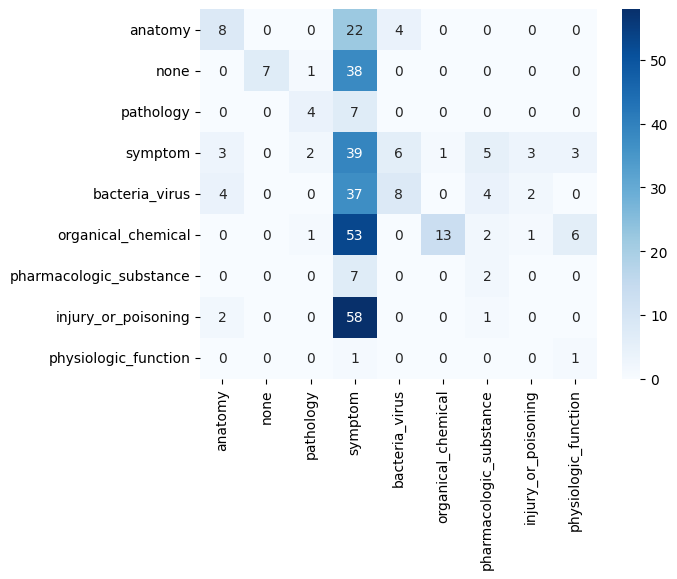

In [65]:
import seaborn as sns

con_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', xticklabels=annotation_table_medical['AV45040|Type'].unique(), yticklabels=annotation_table_medical['AV45040|Type'].unique())

## Entente inter-annotateurs - Analyse par pairs 

### Entente proportionnelle 

Entente proportionnelle entre AU90360 et AV45040
Agreements: 159/356 (44.66%)
Entente proportionnelle entre AU90360 et AV00440
Agreements: 188/356 (52.81%)
Entente proportionnelle entre AV45040 et AU90360
Agreements: 159/356 (44.66%)
Entente proportionnelle entre AV45040 et AV00440
Agreements: 224/356 (62.92%)
Entente proportionnelle entre AV00440 et AU90360
Agreements: 188/356 (52.81%)
Entente proportionnelle entre AV00440 et AV45040
Agreements: 224/356 (62.92%)


Text(0.5, 1.0, 'Proportion of agreement over Medical:Type')

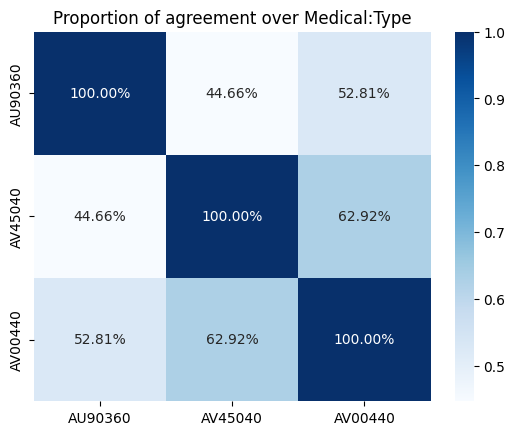

In [66]:
results = np.ones((len(annotators), len(annotators)))

for annotator1, annotator2 in itertools.product(annotators, annotators):
    if annotator1 != annotator2:
        y_true = annotation_table_medical[f'{annotator1}|Type']
        y_pred = annotation_table_medical[f'{annotator2}|Type']
        print(f"Entente proportionnelle entre {annotator1} et {annotator2}")
        # Count aggreements 
        aggreements = (y_true == y_pred).sum()
        total = len(y_true)
        print(f"Agreements: {aggreements}/{total} ({aggreements/total:.2%})")
        results[annotators.index(annotator1), annotators.index(annotator2)] = aggreements / total

sns.heatmap(results, annot=True, fmt='.2%', cmap='Blues', xticklabels=annotators, yticklabels=annotators)   
plt.title('Proportion of agreement over Medical:Type')

### Kappa de Cohen

In [67]:
from sklearn.metrics import cohen_kappa_score



Kappa entre AU90360 et AV45040
Kappa: 0.01509683036780085
Kappa entre AU90360 et AV00440
Kappa: 0.12723452069987018
Kappa entre AV45040 et AU90360
Kappa: 0.01509683036780085
Kappa entre AV45040 et AV00440
Kappa: 0.13646220000735054
Kappa entre AV00440 et AU90360
Kappa: 0.12723452069987018
Kappa entre AV00440 et AV45040
Kappa: 0.13646220000735054


Text(0.5, 1.0, 'Cohen Kappa over Medical:Type')

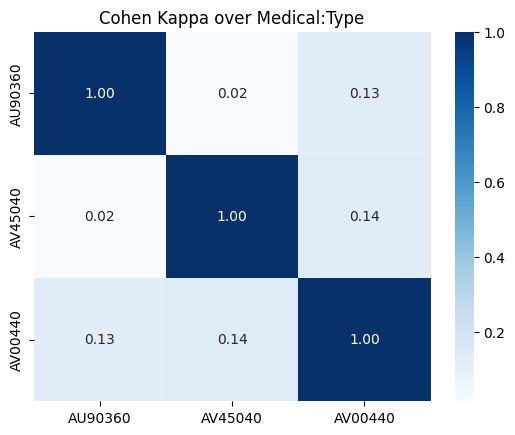

In [68]:
results = np.ones((len(annotators), len(annotators))) 

for annotator1, annotator2 in itertools.product(annotators, annotators):
    if annotator1 != annotator2:
        y_true = annotation_table_medical[f'{annotator1}|Type']
        y_pred = annotation_table_medical[f'{annotator2}|Type']
        print(f"Kappa entre {annotator1} et {annotator2}")
        kappa = cohen_kappa_score(y_true, y_pred)
        print(f"Kappa: {kappa}")
        results[annotators.index(annotator1), annotators.index(annotator2)] = kappa

sns.heatmap(results, annot=True, fmt='.2f', cmap='Blues', xticklabels=annotators, yticklabels=annotators)
plt.title('Cohen Kappa over Medical:Type')




In [69]:
def gwet_ac1(confusion_matrix):
    n = np.sum(confusion_matrix)  # Nombre total d'items annotés
    Q = confusion_matrix.shape[0]  # Nombre de catégories
    diagonal_sum = np.trace(confusion_matrix)  # Accord observé
    
    # Calcul des marges pour chaque catégorie (annotateur 1 + annotateur 2)
    row_sums = np.sum(confusion_matrix, axis=1)
    col_sums = np.sum(confusion_matrix, axis=0)
    p_i = (row_sums + col_sums) / (2 * n)  # Proportion marginale par catégorie
    
    # Accord attendu (Gwet's formula)
    P_e = (1 / (Q - 1)) * np.sum(p_i * (1 - p_i))
    
    # Calcul de AC1
    P_a = diagonal_sum / n
    ac1 = (P_a - P_e) / (1 - P_e)
    return ac1

def cohen_kappa(confusion_matrix):
    total = confusion_matrix.values.sum()
    P_a = np.trace(confusion_matrix) / total  # Accord observé (diagonale)

    # Calcul des marges
    marginal_annot1 = confusion_matrix.sum(axis=1)  # Sommes des lignes (Annotateur 1 : AV00440)
    marginal_annot2 = confusion_matrix.sum(axis=0)  # Sommes des colonnes (Annotateur 2 : AV45040)

    # Accord attendu par chance
    P_e = np.sum(marginal_annot1 * marginal_annot2) / (total ** 2)

    # Formule de Cohen
    kappa = (P_a - P_e) / (1 - P_e)
    return kappa



def pair_agreement_metrics(annotator1, annotator2, annotation_table, col_name):
    data = pd.crosstab(
    index=annotation_table_medical[f'{annotator1}|{col_name}'], 
    columns=annotation_table_medical[f'{annotator2}|{col_name}']
    )
    print(f'Computing agreement metrics between {annotator1} and {annotator2}')
    print(f'over column {col_name}')
    # drop none cols 
    data = data.drop(columns='none', index='none', errors='ignore') 

    # make sure the data is square
    if data.shape[0] != data.shape[1]: 
        print('Data is not square')
        # find the missing columns
        missing_cols = set(data.index) - set(data.columns)
        missing_rows = set(data.columns) - set(data.index)
        print(f'Missing columns: {missing_cols}')
        print(f'Missing rows: {missing_rows}')
        # add the missing columns with 0 values
        for col in missing_cols:
            data[col] = 0
        # add the missing rows with 0 values
        for row in missing_rows:
            data.loc[row] = 0
    # sort the data index and columns
    data = data.reindex(sorted(data.index), axis=0)  # Trier les lignes
    data = data.reindex(sorted(data.columns), axis=1)  # Trier les colonnes
    output = {}

    # Bennett's S
    total = data.values.sum()
    P_a = np.trace(data) / total  # Accord observé
    Q = data.shape[0]  # Nombre de catégories
    S = (P_a - 1/Q) / (1 - 1/Q)
    print(f"Bennett’s S: {S:.3f}")
    output['Bennett’s S'] = S

    # Brute agreement
    accord_brut = np.trace(data) / total
    print(f"Accord Brut: {accord_brut:.3f}")
    output['Brute Agreement'] = accord_brut

    # AC1
    ac1 = gwet_ac1(data.values)
    print(f"AC1: {ac1:.3f}")
    output['AC1'] = ac1

    # Cohen's Kappa
    kappa = cohen_kappa(data)
    print(f"Cohen's Kappa: {kappa:.3f}")
    output["Cohen's Kappa"] = kappa

    # # Comparaison avec la fonction de sklearn 
    # # Convertir la matrice en listes d'annotations
    # annotateur1 = []
    # annotateur2 = []

    # for category in data.index:
    #     for col in data.columns:
    #         count = data.loc[category, col]
    #         annotateur1.extend([category] * count)  # Annotateur 1 (AV00440)
    #         annotateur2.extend([col] * count)       # Annotateur 2 (AV45040)
    
    # # Calculer le Kappa avec sklearn
    # kappa_sklearn = cohen_kappa_score(annotateur1, annotateur2)
    # print(f"Kappa (sklearn): {kappa_sklearn:.3f}")


    return output
    



pair_agreement_metrics('AV00440', 'AV45040', annotation_table_medical, 'Type')
print('\n')
pair_agreement_metrics('AV00440', 'AU90360', annotation_table_medical, 'Type')
print('\n')
pair_agreement_metrics('AU90360', 'AV45040', annotation_table_medical, 'Type')




Computing agreement metrics between AV00440 and AV45040
over column Type
Data is not square
Missing columns: set()
Missing rows: {'symptom'}
Bennett’s S: 0.467
Accord Brut: 0.533
AC1: 0.476
Cohen's Kappa: 0.408


Computing agreement metrics between AV00440 and AU90360
over column Type
Data is not square
Missing columns: {'pharmacologic_substance', 'injury_or_poisoning'}
Missing rows: set()
Bennett’s S: 0.900
Accord Brut: 0.914
AC1: 0.902
Cohen's Kappa: 0.889


Computing agreement metrics between AU90360 and AV45040
over column Type
Data is not square
Missing columns: set()
Missing rows: {'symptom', 'pharmacologic_substance', 'injury_or_poisoning'}
Bennett’s S: 0.377
Accord Brut: 0.455
AC1: 0.384
Cohen's Kappa: 0.332


{'Bennett’s S': 0.3766233766233766,
 'Brute Agreement': 0.45454545454545453,
 'AC1': 0.38399999999999995,
 "Cohen's Kappa": 0.33183352080989875}

In [70]:



pair_agreement_metrics('AV00440', 'AV45040', annotation_table_both_layer, 'Type')
print('\n')
pair_agreement_metrics('AV00440', 'AU90360', annotation_table_both_layer, 'Type')
print('\n')
pair_agreement_metrics('AU90360', 'AV45040', annotation_table_both_layer, 'Type')




Computing agreement metrics between AV00440 and AV45040
over column Type
Data is not square
Missing columns: set()
Missing rows: {'symptom'}
Bennett’s S: 0.467
Accord Brut: 0.533
AC1: 0.476
Cohen's Kappa: 0.408


Computing agreement metrics between AV00440 and AU90360
over column Type
Data is not square
Missing columns: {'pharmacologic_substance', 'injury_or_poisoning'}
Missing rows: set()
Bennett’s S: 0.900
Accord Brut: 0.914
AC1: 0.902
Cohen's Kappa: 0.889


Computing agreement metrics between AU90360 and AV45040
over column Type
Data is not square
Missing columns: set()
Missing rows: {'symptom', 'pharmacologic_substance', 'injury_or_poisoning'}
Bennett’s S: 0.377
Accord Brut: 0.455
AC1: 0.384
Cohen's Kappa: 0.332


{'Bennett’s S': 0.3766233766233766,
 'Brute Agreement': 0.45454545454545453,
 'AC1': 0.38399999999999995,
 "Cohen's Kappa": 0.33183352080989875}

## EIA: Analyse globale des annotations 

### Kappa de Fleiss (pas applicable ici)

## Jaccard pour comparer les spans entre eux 


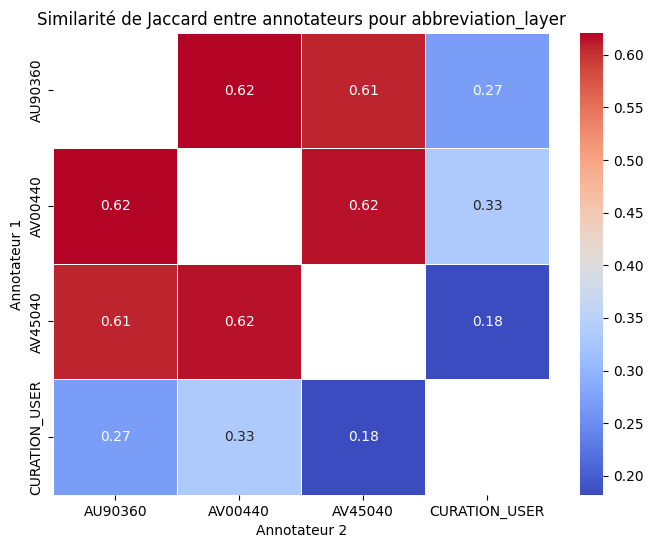

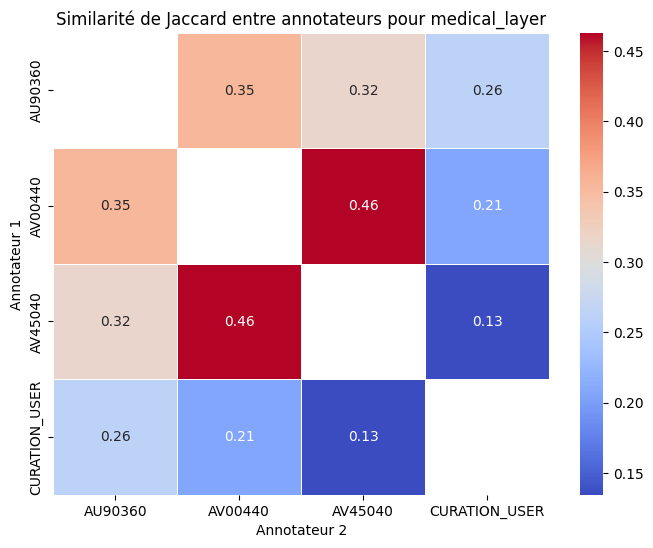

In [96]:
from itertools import combinations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def jaccard_similarity(set1, set2): #comparaison des spans annotes entre deux annotateurs set1 et set2
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

def compute_jaccard_scores(annotation_table):

    # regroupe les annotations par document
    grouped = annotation_table.groupby("Document").apply(
        lambda df: {
            annot: set(zip(df["Début"], df["Fin"], df[f"{annot}|Type"]))
            for annot in [col.split("|")[0] for col in df.columns if "|Layer" in col]
        }
    )

    results = []
    
    for document, annotations in grouped.items():
        annotators = list(annotations.keys())
        for annot1, annot2 in combinations(annotators, 2):
            score = jaccard_similarity(annotations[annot1], annotations[annot2])
            results.append({"Document": document, "Annotateur 1": annot1, "Annotateur 2": annot2, "Jaccard": score})
    
    return pd.DataFrame(results)

def plot_jaccard_heatmap(jaccard_scores, layer):
    """
    Génère une heatmap des scores de Jaccard entre annotateurs en moyennant les doublons.
    """
    # Moyenne des scores de Jaccard en cas de doublons
    avg_jaccard_scores = jaccard_scores.groupby(["Annotateur 1", "Annotateur 2"]).agg({"Jaccard": "mean"}).reset_index()

    # Création de la matrice de similarité
    pivot_df = avg_jaccard_scores.pivot(index="Annotateur 1", columns="Annotateur 2", values="Jaccard")

    # Compléter la matrice pour qu'elle soit symétrique
    full_matrix = pivot_df.combine_first(pivot_df.T)

    # Création de la figure avec une heatmap colorée
    plt.figure(figsize=(8, 6))
    sns.heatmap(full_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

    plt.title("Similarité de Jaccard entre annotateurs pour " + layer)
    plt.xlabel("Annotateur 2")
    plt.ylabel("Annotateur 1")
    plt.show()


# Application sur le tableau de donnees de la couche médicale et abbréviation
jaccard_scores_abbreviation = compute_jaccard_scores(annotation_table_abbreviation)
jaccard_scores_medical = compute_jaccard_scores(annotation_table_medical)

# Affichage du heatmap
plot_jaccard_heatmap(jaccard_scores_abbreviation, 'abbreviation_layer')
plot_jaccard_heatmap(jaccard_scores_medical, 'medical_layer')